In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Load dataset
df = pd.read_csv("lstm_ready_traffic_data.csv")
scaler = MinMaxScaler()
df['scaled_traffic_volume'] = scaler.fit_transform(df[['Total_Traffic_Volume']])
# If 'day_of_week' is text, convert to numeric
if df['day_of_week'].dtype == 'object':
    df['day_of_week'] = df['day_of_week'].astype('category').cat.codes

# Select features and target
features = ['hour', 'day_of_week', 'month', 'year', 'road_name_encoded',
            'location_encoded', 'suburb_encoded', 'average_speed',
            'maximum_speed', 'Speeding_Incident', 'Speeding_Incident_Avg_Speed']
target = 'scaled_traffic_volume'

# Convert features and target to float32 (required by LSTM)
X = df[features].values.astype('float32')
y = df[target].values.astype('float32')

# Create sequences
def create_sequences(X, y, time_steps=48):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X, y)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

# Build the LSTM model
model_multi = Sequential()
model_multi.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_multi.add(Dropout(0.2))
model_multi.add(LSTM(32, activation='relu'))
model_multi.add(Dropout(0.2))
model_multi.add(Dense(1))
model_multi.compile(optimizer='adam', loss='mse')
model_multi.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=64,
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
789/789 ━━━━━━━━━━━━━━━━━━━━ 64s 75ms/step - loss: 1234252.6250 - val_loss: 16631.6465
Epoch 2/20
789/789 ━━━━━━━━━━━━━━━━━━━━ 81s 75ms/step - loss: 6620.8926 - val_loss: 6034.8467
Epoch 3/20
789/789 ━━━━━━━━━━━━━━━━━━━━ 80s 72ms/step - loss: 2699.8613 - val_loss: 2615.9270
Epoch 4/20
789/789 ━━━━━━━━━━━━━━━━━━━━ 59s 74ms/step - loss: 1456.2886 - val_loss: 4199.1558
Epoch 5/20
789/789 ━━━━━━━━━━━━━━━━━━━━ 57s 73ms/step - loss: 1901.5443 - val_loss: 107.5856
Epoch 6/20
789/789 ━━━━━━━━━━━━━━━━━━━━ 85s 77ms/step - loss: 716.4293 - val_loss: 0.8324
Epoch 7/20
789/789 ━━━━━━━━━━━━━━━━━━━━ 63s 80ms/step - loss: 251.8264 - val_loss: 0.2099
Epoch 8/20
789/789 ━━━━━━━━━━━━━━━━━━━━ 59s 75ms/step - loss: 297.9683 - val_loss: 0.2589
Epoch 9/20
789/789 ━━━━━━━━━━━━━━━━━━━━ 88s 82ms/step - loss: 154.1854 - val_loss: 3.2339
Epoch 10/20
789/789 ━━━━━━━━━━━━━━━━━━━━ 77s 75ms/step - loss: 194.8796 - val_loss: 0.0426
Epoch 11/20
789/789 ━━━━━━━━━━━━━━━━━━━━ 81s 74ms/step - loss: 311.4881 - va

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Predict
y_pred_multi = model_multi.predict(X_test)

# Metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred_multi))
mae = mean_absolute_error(y_test, y_pred_multi)
r2 = r2_score(y_test, y_pred_multi)
mse = mean_squared_error(y_test, y_pred_multi)

# Results
print("\n✅ Two-Layer LSTM + Dropout (with EarlyStopping and window size 48):")
print(f"🔹 RMSE: {rmse:.4f}")
print(f"🔹 MAE : {mae:.4f}")
print(f"🔹 R²  : {r2:.4f}")
print(f"🔹 MSE : {mse:.4f}")


395/395 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step

✅ Two-Layer LSTM + Dropout (with EarlyStopping and window size 48):
🔹 RMSE: 2.4645
🔹 MAE : 1.5351
🔹 R²  : -780.3953
🔹 MSE : 6.0740


<ipython-input-3-97282268e2ca>:12: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


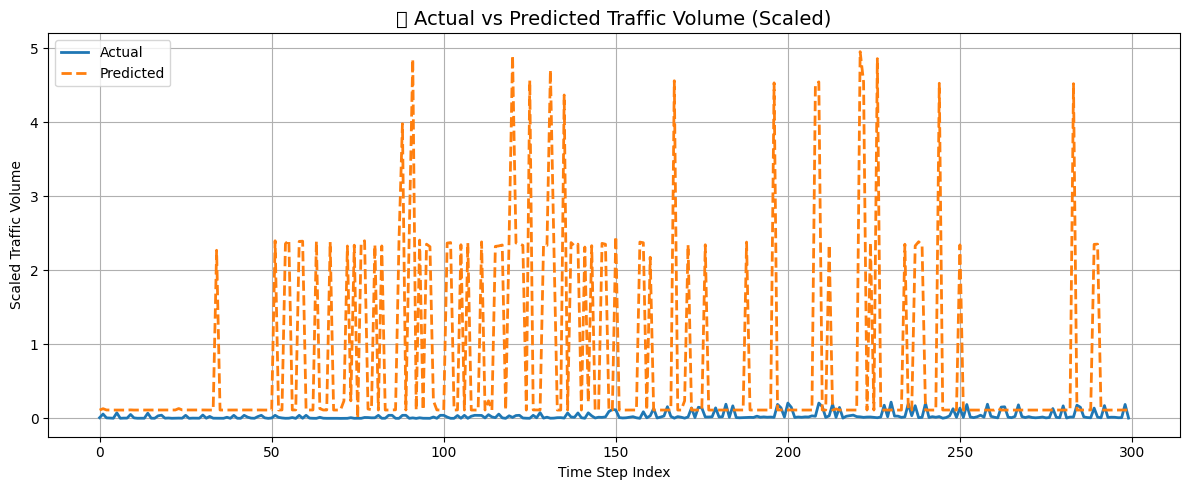

In [ ]:
import matplotlib.pyplot as plt

# Plot first 300 predictions for visual clarity
plt.figure(figsize=(12, 5))
plt.plot(y_test[:300], label='Actual', linewidth=2)
plt.plot(y_pred_multi[:300], label='Predicted', linewidth=2, linestyle='--')
plt.title('📊 Actual vs Predicted Traffic Volume (Scaled)', fontsize=14)
plt.xlabel('Time Step Index')
plt.ylabel('Scaled Traffic Volume')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-4-97282268e2ca>:12: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


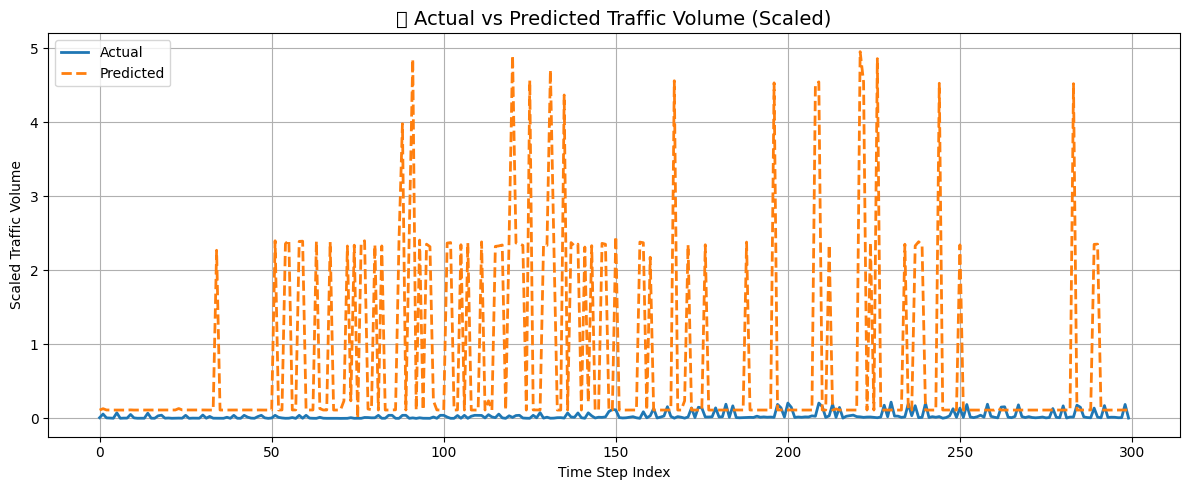

In [ ]:
import matplotlib.pyplot as plt

# Plot first 300 predictions for visual clarity
plt.figure(figsize=(12, 5))
plt.plot(y_test[:300], label='Actual', linewidth=2)
plt.plot(y_pred_multi[:300], label='Predicted', linewidth=2, linestyle='--')
plt.title('📊 Actual vs Predicted Traffic Volume (Scaled)', fontsize=14)
plt.xlabel('Time Step Index')
plt.ylabel('Scaled Traffic Volume')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',      # Watch validation loss
    patience=5,              # Stop after 3 epochs without improvement
    restore_best_weights=True  # Revert to best weights
)

In [ ]:
from tensorflow.keras.layers import Bidirectional
bilstm_model = Sequential()

bilstm_model.add(Bidirectional(LSTM(64, activation='relu', return_sequences=True)))
bilstm_model.add(Dropout(0.2))
bilstm_model.add(Bidirectional(LSTM(32, activation='relu')))
bilstm_model.add(Dropout(0.2))
bilstm_model.add(Dense(1))

# Compile
bilstm_model.compile(optimizer='adam', loss='mse')

# Train
bilstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=64, callbacks=[early_stop], verbose=1)


Epoch 1/30
789/789 ━━━━━━━━━━━━━━━━━━━━ 136s 153ms/step - loss: 552332416.0000 - val_loss: 60067.3477
Epoch 2/30
789/789 ━━━━━━━━━━━━━━━━━━━━ 136s 146ms/step - loss: 1048335.7500 - val_loss: 10244.0938
Epoch 3/30
789/789 ━━━━━━━━━━━━━━━━━━━━ 119s 150ms/step - loss: 134017.1875 - val_loss: 7807.9644
Epoch 4/30
789/789 ━━━━━━━━━━━━━━━━━━━━ 115s 146ms/step - loss: 10452.7773 - val_loss: 7011.5039
Epoch 5/30
789/789 ━━━━━━━━━━━━━━━━━━━━ 145s 150ms/step - loss: 7976.6851 - val_loss: 5461.5952
Epoch 6/30
789/789 ━━━━━━━━━━━━━━━━━━━━ 136s 143ms/step - loss: 7494.7383 - val_loss: 7327.4478
Epoch 7/30
789/789 ━━━━━━━━━━━━━━━━━━━━ 148s 151ms/step - loss: 4680.7925 - val_loss: 3327.5142
Epoch 8/30
789/789 ━━━━━━━━━━━━━━━━━━━━ 136s 144ms/step - loss: 30247.2988 - val_loss: 2847.1443
Epoch 9/30
789/789 ━━━━━━━━━━━━━━━━━━━━ 139s 140ms/step - loss: 1672.9663 - val_loss: 2031.2822
Epoch 10/30
789/789 ━━━━━━━━━━━━━━━━━━━━ 145s 145ms/step - loss: 1138.6688 - val_loss: 1712.2617
Epoch 11/30
789/789 ━━━━━

In [ ]:
# Predict
y_pred_bilstm = bilstm_model.predict(X_test)

# Metrics
rmse_bi = np.sqrt(mean_squared_error(y_test, y_pred_bilstm))
mae_bi = mean_absolute_error(y_test, y_pred_bilstm)
r2_bi = r2_score(y_test, y_pred_bilstm)
mse_bi = mean_squared_error(y_test, y_pred_bilstm)

# Results
print("\n✅ Bidirectional LSTM Model Results:")
print(f"🔹 RMSE: {rmse_bi:.4f}")
print(f"🔹 MAE : {mae_bi:.4f}")
print(f"🔹 R²  : {r2_bi:.4f}")
print(f"🔹 MSE : {mse_bi:.4f}")

395/395 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step

✅ Bidirectional LSTM Model Results:
🔹 RMSE: 4.7411
🔹 MAE : 0.5359
🔹 R²  : -2890.6575
🔹 MSE : 22.4777


In [ ]:
from tensorflow.keras.layers import Bidirectional
tribilstm_model = Sequential()
tribilstm_model.add(Bidirectional(LSTM(128, activation='relu', return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
tribilstm_model.add(Dropout(0.2))
tribilstm_model.add(Bidirectional(LSTM(64, activation='relu', return_sequences=True)))
tribilstm_model.add(Dropout(0.2))
tribilstm_model.add(Bidirectional(LSTM(32, activation='relu')))
tribilstm_model.add(Dropout(0.2))
tribilstm_model.add(Dense(1))

# Compile
bilstm_model.compile(optimizer='adam', loss='mse')

# Train
bilstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=64, callbacks=[early_stop], verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
789/789 ━━━━━━━━━━━━━━━━━━━━ 124s 146ms/step - loss: 504166.9688 - val_loss: 8948.0400
Epoch 2/30
789/789 ━━━━━━━━━━━━━━━━━━━━ 116s 146ms/step - loss: 2016.0109 - val_loss: 9.2986
Epoch 3/30
789/789 ━━━━━━━━━━━━━━━━━━━━ 117s 148ms/step - loss: 284.5079 - val_loss: 0.5773
Epoch 4/30
789/789 ━━━━━━━━━━━━━━━━━━━━ 138s 143ms/step - loss: 255.6064 - val_loss: 16.8652
Epoch 5/30
789/789 ━━━━━━━━━━━━━━━━━━━━ 141s 143ms/step - loss: 289.2159 - val_loss: 1.1985
Epoch 6/30
789/789 ━━━━━━━━━━━━━━━━━━━━ 142s 143ms/step - loss: 639.2002 - val_loss: 0.1275
Epoch 7/30
789/789 ━━━━━━━━━━━━━━━━━━━━ 114s 145ms/step - loss: 58.5324 - val_loss: 4.6455
Epoch 8/30
789/789 ━━━━━━━━━━━━━━━━━━━━ 116s 146ms/step - loss: 25.6097 - val_loss: 0.2928
Epoch 9/30
789/789 ━━━━━━━━━━━━━━━━━━━━ 111s 141ms/step - loss: 15.5173 - val_loss: 93.0827
Epoch 10/30
789/789 ━━━━━━━━━━━━━━━━━━━━ 141s 140ms/step - loss: 36.1424 - val_loss: 94.8517
Epoch 11/30
789/789 ━━━━━━━━━━━━━━━━━━━━ 114s 144ms/step - loss: 9.5208 -

In [ ]:
y_pred_tribilstm = tribilstm_model.predict(X_test)

# Metrics
rmse_bi = np.sqrt(mean_squared_error(y_test, y_pred_tribilstm))
mae_bi = mean_absolute_error(y_test, y_pred_tribilstm)
r2_bi = r2_score(y_test, y_pred_tribilstm)
mse_bi = mean_squared_error(y_test, y_pred_tribilstm)

# Results
print("\n✅ 3 Layer Bidirectional LSTM Model Results:")
print(f"🔹 RMSE: {rmse_bi:.4f}")
print(f"🔹 MAE : {mae_bi:.4f}")
print(f"🔹 R²  : {r2_bi:.4f}")
print(f"🔹 MSE : {mse_bi:.4f}")

395/395 ━━━━━━━━━━━━━━━━━━━━ 35s 88ms/step

✅ 3 Layer Bidirectional LSTM Model Results:
🔹 RMSE: 136251.0774
🔹 MAE : 31605.3438
🔹 R²  : -2388227260416.0000
🔹 MSE : 18564356096.0000
